In [60]:
import py3Dmol
from ipywidgets import interact, interactive, fixed # For interactive display of conformers
from espsim import EmbedAlignConstrainedScore, EmbedAlignScore, ConstrainedEmbedMultipleConfs, GetEspSim, GetShapeSim
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdMolDescriptors
from Bio import PDB
from rdkit.Chem.Draw import IPythonConsole
from copy import deepcopy
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"


import safe as sf
import datamol as dm

In [16]:
from collections import defaultdict

In [7]:
import numpy as np

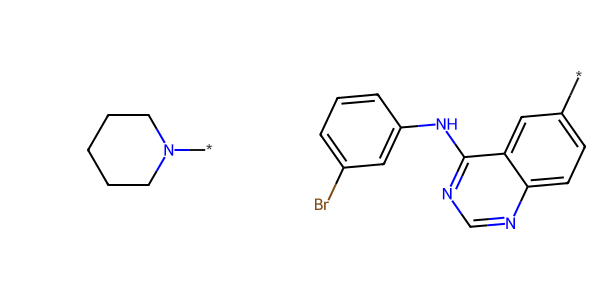

In [2]:
fragment1 = "[*]-N1CCCCC1"
fragment2 = "Brc1cccc(Nc2ncnc3ccc(-[*])cc23)c1"

linker_generation = [fragment1, fragment2]

dm.to_image(linker_generation)

In [13]:
def download_pdb(pdb_id):
    pdb_list = PDB.PDBList()
    filename = pdb_list.retrieve_pdb_file(pdb_id, file_format="pdb", pdir=".")
    return filename

In [19]:
def find_ligands(pdb_file):
    parser = PDB.PDBParser()
    structure = parser.get_structure('structure', pdb_file)
    ligands = defaultdict(lambda: defaultdict(list))

    for model in structure:
        for chain in model:
            chain_id = chain.id
            for residue in chain:
                if residue.id[0] != ' ':  # Check if it's a heteroatom
                    ligands[chain_id][residue.resname].append(residue)
    
    return ligands

In [6]:
def extract_ligand_coords(ligand):
    return np.array([atom.coord for atom in ligand])

In [8]:
def create_mol_from_coords(coords, mol_string):
    mol = Chem.MolFromSmiles(mol_string)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=42)
    conf = mol.GetConformer()
    for i, coord in enumerate(coords):
        conf.SetAtomPosition(i, coord)
    return mol

In [11]:
pdb_id = "8df9"
pdb_filename = f"{pdb_id}.pdb"
if not os.path.exists(pdb_filename):
    from Bio.PDB import PDBList
    pdbl = PDBList()
    pdbl.retrieve_pdb_file(pdb_id, pdir='.', file_format='pdb')

Structure exists: './pdb8df9.ent' 


In [20]:
pdb_id = "8DF9"
pdb_file = download_pdb(pdb_id)
ligands = find_ligands(pdb_file)

Structure exists: './pdb8df9.ent' 


/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 16929.
  warnings.warn(
/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 16934.
  warnings.warn(
/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain S is discontinuous at line 16941.
  warnings.warn(
/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain T is discontinuous at line 16942.
  warnings.warn(
/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Ch

In [12]:
pdb_file

'8DF9.pdb'

In [22]:
ligands['A']['MG']

[<Residue MG het=H_MG resseq=901 icode= >,
 <Residue MG het=H_MG resseq=902 icode= >,
 <Residue MG het=H_MG resseq=903 icode= >,
 <Residue MG het=H_MG resseq=904 icode= >,
 <Residue MG het=H_MG resseq=905 icode= >]

In [24]:
ligand_coords = extract_ligand_coords(ligands['A']['MG'][0])

In [32]:
sdf_file_path = '8fd9_ligand.sdf'
suppl = Chem.SDMolSupplier(sdf_file_path, removeHs=False)
ligand = next(suppl)

In [30]:
def draw(ms,p=None, confIds=None):
    if p is None:
        p = py3Dmol.view(width=400, height=400)
    if confIds is None:
        confIds = [-1]*len(ms)
    p.removeAllModels()
    for i,m in enumerate(ms):
        mb=Chem.MolToMolBlock(m, confId=confIds[i])
        p.addModel(mb, 'sdf')
        p.setStyle({'model':i},{'stick':{'radius':0.15}})
    p.setBackgroundColor('white')#'0xeeeeee')
    p.zoomTo()
    return p.show()

In [37]:
ligand.GetNumConformers()

1

In [39]:

draw([ligand])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [41]:
def embed(mol,n=10):
    if mol is not None:
        ps = AllChem.ETKDGv2()
        ps.useRandomCoords=False
        AllChem.EmbedMultipleConfs(mol, n, ps)
        if mol.GetNumConformers() != n:
            print("could not embed, trying random coordinates for initialization")
            ps.useRandomCoords=True
            AllChem.EmbedMultipleConfs(mol, n, ps)
        if mol.GetNumConformers() != n:
            print("could not embed")
            return None
    return mol

In [43]:
m1 = Chem.AddHs(Chem.MolFromSmiles("c1ccccc1Cl"))
m2 = Chem.AddHs(Chem.MolFromSmiles("c1ccccc1[N+]([O-])=O"))

m1 = embed(m1, n=2)
m2 = embed(m2, n=2)

draw([m1,m2])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

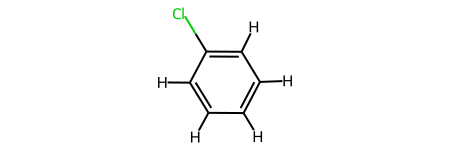

In [44]:
m1

In [74]:
ligand_drawn = Chem.MolFromSmiles(Chem.MolToSmiles(ligand))

In [75]:
ligand_drawn.GetNumConformers()

0

In [100]:
ligand_drawn = Chem.AddHs(ligand_drawn) # <- add hydrogens so that we get a reasonable conformer
AllChem.EmbedMultipleConfs(ligand_drawn,1000, randomSeed=0xf00d) # <- generate 10 conformers
print(ligand_drawn.GetNumConformers(),ligand_drawn.GetConformer().Is3D())

1000 True


In [58]:
draw([ligand_drawn], confIds=[3])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [50]:
def align(prbMol, refMol, prbCrippen=None, refCrippen=None, i=-1, j=-1):
    if prbCrippen is None:
        prbCrippen = rdMolDescriptors._CalcCrippenContribs(prbMol)
    if refCrippen is None:
        refCrippen = rdMolDescriptors._CalcCrippenContribs(refMol)
    alignment = rdMolAlign.GetCrippenO3A(prbMol, refMol, prbCrippen, refCrippen, i, j)
    alignment.Align()

In [101]:
all_sims = {'conformer':[], 'shape': [], 'esp': []}
for i in range(ligand_drawn.GetNumConformers()):
    # print(i)
    prbMol=deepcopy(ligand)
    # ref_copy = Chem.Mol(ligand_drawn, confId=i)
    # refMol=deepcopy(ref_copy)
    # align(prbMol, refMol)
    rdMolAlign.GetBestRMS(prbMol,ligand_drawn,prbId=0,refId=i)
    shape_sim = GetShapeSim(prbMol, ligand_drawn, prbCid=0, refCid=i)
    esp_sim = GetEspSim(prbMol, ligand_drawn, prbCid=0, refCid=i)
    all_sims['conformer'].append(i)
    all_sims['shape'].append(shape_sim)
    all_sims['esp'].append(esp_sim)
    
    


/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/espsim/helpers.py:18: UserWarning: Input molecule missing hydrogens. Use Chem.AddHs() to make hydrogens explicit.
  warnings.warn('Input molecule missing hydrogens. Use Chem.AddHs() to make hydrogens explicit.')


In [59]:
ligand_drawn.GetConformer(4)

In [65]:
ligand_drawn.GetConformer(1)

In [69]:
import pandas as pd

In [102]:
df = pd.DataFrame.from_dict(all_sims)

In [103]:
df.sort_values('shape', ascending=False)

,conformer,shape,esp
611,611,0.699613,0.306189
734,734,0.684593,0.293583
936,936,0.679255,0.278913
111,111,0.672862,0.513456
992,992,0.669265,0.505264
...,...,...,...
560,560,0.290623,0.317229
982,982,0.289915,0.334722
753,753,0.288887,0.305373
515,515,0.283983,0.310248


In [93]:
draw([Chem.Mol(ligand_drawn,  ligand_drawn.GetConformer(1))])

ArgumentError: Python argument types in
    Mol.__init__(Mol, Mol, Conformer)
did not match C++ signature:
    __init__(_object* self, RDKit::ROMol mol, bool quickCopy=False, int confId=-1)
    __init__(_object* self, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> pklString, unsigned int propertyFlags)
    __init__(_object* self, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> pklString)
    __init__(_object* self)

In [107]:
rdMolAlign.GetBestRMS(ligand,ligand_drawn,prbId=0,refId=611)
GetShapeSim(ligand, ligand_drawn, prbCid=0, refCid=611)

0.6996126060098419

In [133]:
EmbedAlignScore(Chem.AddHs(ligand), Chem.AddHs(Chem.Mol(ligand_drawn, 0)), renormalize=True, prbNumConfs=20, refNumConfs=20)

([0.9319752203955206], [0.9418561127410942])

In [136]:
nolutinib = Chem.MolFromSmiles('CC#CC(=O)N1CCC[C@H]1c1cc(-c2ccc(cc2)C(=O)Nc2ccccn2)c2c(C)nc(C)c(C)n12')

In [137]:
EmbedAlignScore(Chem.AddHs(ligand), Chem.AddHs(nolutinib), renormalize=True, prbNumConfs=20, refNumConfs=20)

([0.7483984294275676], [0.9423019438482562])

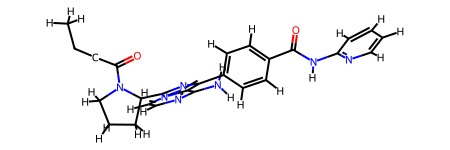

In [117]:
ligand